# Chapter 7 蒙特卡罗方法
## 1.1 Math theory
MC 的核心是大数定理以实验平均值估计期望，即从某种角度此类问题都在计算期望。
### 1.1.1 大数定律
When the time $\rightarrow\infin$, 平均值和期望相等。
### 1.1.2 中心极限定理
它指出在一定条件下，独立（independent）随机变量的标准化的（normalized）和随样本量（sample size）变大会趋向正态分布（normal distribution），即它的累积分布函数（cumulative distribution function/CDF）会收敛于标准正态分布（standard normal distribution）的CDF。中心极限定理不要求随机变量本身是正态分布的，所以它带来一个非常重要的结果

但注意，他需要从里面分裂出一个事件，比如“一共找100次在0-0.5之内找到粒子的次数”作为一个数据点x，多次实验x会有不同数值,可以记下每一个x对应的频数P。则x-P满足正太分布。
* instance for proof

用的一维无限深势阱激发态波函数，计x小于0.5为1个事件，可见500次结果接近正态分布。
$$
\begin{cases}
\psi(x)=\sqrt{2}\sin(2\pi x)\\
x\in [0,1]
\end{cases}
$$
我们随机测量粒子，其位置在dx之内的概率为：
$$
P=\int_{dx}2\sin^2(2\pi x) dx=[x-\frac{1}{4\pi}\sin(4\pi x)]|_{dx}
$$

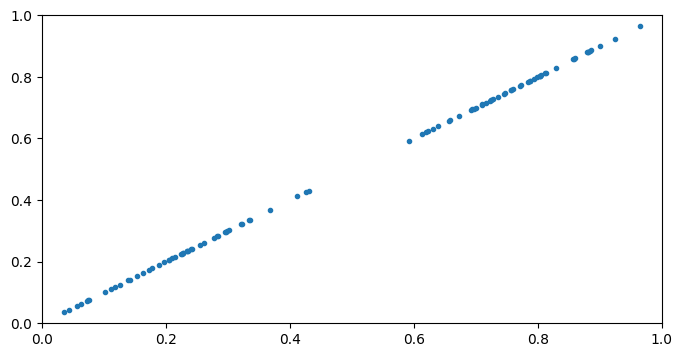

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 自定义分布
## 自定义概率密度函数
def custom_pdf(x):
    return 2*(np.sin(2*np.pi*x))**2  # 以指数分布为例，也可以根据需要定义其他分布
## 创建自定义分布对象
custom_dist = stats.rv_continuous(name='Custom_Distribution', a=0, b=1)
custom_dist._pdf = custom_pdf
## 生成符合自定义分布的随机数
random_numbers = custom_dist.rvs(size=100)

# graph
fig= plt.figure(figsize=(8,4))
ax= fig.add_subplot(1,1,1)
ax.plot(random_numbers,random_numbers,linestyle='',marker='.')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

元素列表: [21.0, 28.0, 25.0, 19.0, 26.0, 24.0, 32.0, 20.0, 27.0, 22.0, 23.0, 30.0, 18.0, 31.0, 29.0, 34.0, 33.0, 35.0, 17.0, 16.0]
频数列表: [31, 38, 42, 14, 55, 62, 13, 19, 52, 46, 37, 20, 15, 14, 30, 3, 5, 1, 2, 1]


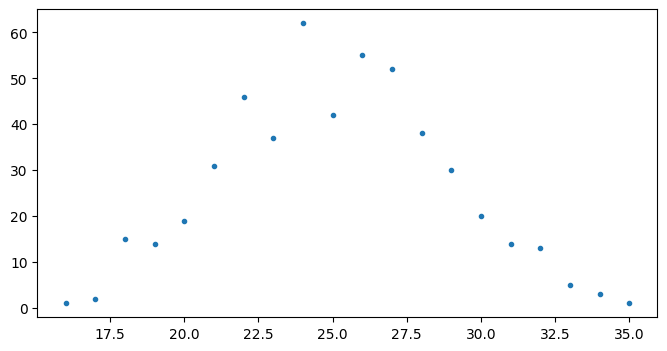

In [2]:
douc=np.array([])
for i in range(500): #500个数据点
    random_numbers = custom_dist.rvs(size=50)
    n=np.size(random_numbers[random_numbers<=0.5])
    douc=np.append(douc,n)


from collections import Counter
# 使用Counter类统计元素频数
counter = Counter(douc)

# 将频数统计结果转换为两个列表
elements = list(counter.keys())
frequencies = list(counter.values())
print("元素列表:", elements)
print("频数列表:", frequencies)
# graph
fig= plt.figure(figsize=(8,4))
ax= fig.add_subplot(1,1,1)
ax.plot(elements,frequencies,linestyle='',marker='.')
plt.show()

### 1.1.3 Importance Sampling
Now I have doubted its practicality.
#### 1.1.3.1 premise
* 概率分布为p(x),f(x)理论期望求法。
$$
\langle f(x)\rangle_x=\int_a^b f(x)p(x) dx
$$
* 如果是用采样集估计平均值，那我们只要保证采样集的概率分布也是 $p(x)$（从数据库均匀采样），那么直接对采样点算术平均即可，因为 $p(x)$ 已经包含在 $f(x_i)$ 频数分布/N。
$$
\langle f(x)\rangle_x\approx\frac{1}{N}\sum_{i=1}^N f(x_i) 
$$
你应该发现其优势了，只要可以模拟采样，不需要只要 $p(x)$ 形式即可计算平均。
* 如果做MC,那产生随机数分布要按照 $p(x)$， 然后对采样点求算术平均即可。
#### 1.1.3.2 definition
就是说我们不想按数据库按照 $p(x)$ 均匀采样。
$$
\langle f(x)\rangle_x=\int_a^b f(x)p(x) dx=\int_a^b \pi(x) \frac{p(x)}{\pi(x)} f(x) dx
$$
然后按 $\pi(x)$ 采样,显然要用权重弥补以下。
$$
\langle f(x)\rangle_x\approx\frac{1}{N}\sum_{i=1}^N \frac{p(x_i)}{\pi(x_i)} f(x_i)
$$
#### 1.1.3.3 统计应用场景
可能是和目标数据库一样符合 $p(x)$ 分布的 $f(x)$ 不大好找，是身边只有 $\pi(x)$。比如想统计整个学校的平均身高$f(x)$,x为“物理水平”。虽然只能在物理系抽样本，但是知道身高在物理系和全校的分布分别为 $\pi(x)$ 和 $f(x)$，所以还是可以算的。
#### 1.1.3.4 MC应用
##### 1.1.3.4.1 理论
一般理论值是均匀分布，即 $p(x)=\frac{1}{b-a}$
$$
\langle f(x)\rangle_x=\frac{1}{b-a}\int_a^b f(x)dx
$$
保证理论均匀连续积分不变的同时，我们想在敏感位置投掷给多的采样点，设计符合条件的分布函数 $\pi(x)$
$$
\langle f(x)\rangle_x=\int_a^b \pi(x)*\frac{\frac{1}{b-a}}{\pi(x)}f(x)dx
$$
实际生成符合 $\pi(x)$ 的采样点 $f(x_i)$
$$
\langle f(x)\rangle_x\approx\sum_{i=1}^N \frac{\frac{1}{b-a}}{\pi(x_i)}f(x_i)
$$
##### 1.1.3.4.2 辅助工具：常用概率分布函数beta
* 数学形式
$ 
B(\alpha, \beta) = \int_0^1 t^{\alpha-1} (1-t)^{\beta-1} dt 
$ 

$ 
f(t; \alpha, \beta) = \frac{t^{\alpha-1} (1-t)^{\beta-1}}{B(\alpha, \beta)} 
$ 

Beta分布的形状取决于参数$\alpha$和$\beta$： 
- 当$\alpha = \beta = 1$时，Beta分布退化为均匀分布。 
- 当$\alpha > 1$且$\beta > 1$时，分布是单峰的，峰值出现在$(\alpha - 1) / (\alpha + \beta - 2)$。这两个参数越大越尖锐。
- 当$\alpha < 1$且$\beta < 1$时，分布在两端高中间低，形成所谓的U形。 
- 当$\alpha > \beta$时，分布偏向于0的方向。 
- 当$\alpha < \beta$时，分布偏向于1的方向。
* python内置
已经内置了归一化的 $f(t; \alpha, \beta)$,但是积分范围只能是0-1：
```python
from scipy.stats import beta

# 计算pdf,概率密度函数
pdf = beta.pdf(x, alpha, beta_)
# 计算CDF，累积分布函数
cdf = beta.cdf(x, alpha, beta_)
# 生成beta分布。
samples = beta.rvs(alpha, beta_, size=100)
```
##### 1.1.3.4.2 问题：多变量几乎玩不了。


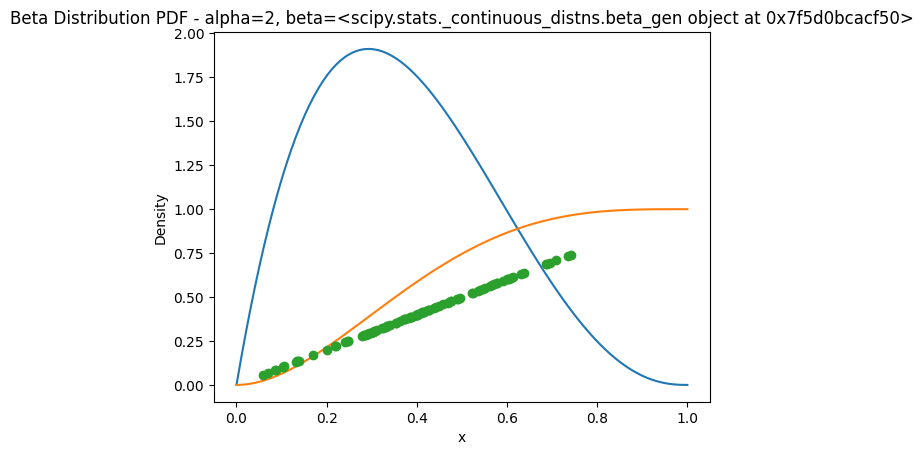

In [3]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

# 设置参数 alpha 和 beta
alpha, beta_ = 2, 1/(1-np.sqrt(2)/2)
# 创建一个表示概率的x轴数据
x = np.linspace(0, 1, 100)


# 创建一个表示概率的x轴数据
x = np.linspace(0, 1, 100)

# 计算PDF
pdf = beta.pdf(x, alpha, beta_)
# 生成100个随机样本
samples = beta.rvs(alpha, beta_, size=100)
# 计算CDF
cdf = beta.cdf(x, alpha, beta_)

# 绘图
plt.plot(x, pdf)
plt.plot(x, cdf)
plt.plot(samples,samples,marker='o',linestyle='')
plt.title(f'Beta Distribution PDF - alpha={alpha}, beta={beta}')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

### 1.1.4 分层抽样

假如我们将随机区间分成子区间，按正常的随机抽样，投入点数理应正比于子空间占比，此时各子区间结果重要程度正比子区间占比。如果我们不想均匀取点，理应对子区间重要性加权。

$$
\langle f(\vec x) \rangle= \sum_i \frac{S_i}{S}\langle f(\vec x)\rangle_i
$$ 

其中 $\langle f(\vec x)\rangle_i$ 为取点数正比于子区间占比时每个子区间的计算结果。$\langle g(\vec x)\rangle_i$ 为取点数和子区间占比无关时每个子区间的计算结果。

$\frac{\rho_s}{\rho_i}$ 这i个区域权重需要归一 

现在我们可以进一步简化，令子区间体积相同,那么计算公式简化为：
$$
\langle f(\vec x) \rangle= \propto \rho\sum_i \langle g(\vec x)\rangle_i
$$ 
这个操作在子区间不多时几乎不会增加数值计算复杂度，却令人心情愉悦。

* 可以对 $\theta$ 也空间划分，资源倾斜，即为5*5空间。
```python
rescource_ratio=np.array([1*np.array([1,1,1,2,3]),\
                         3*np.array([1,1,2,3,1]),\
                         2*np.array([1,1,3,2,1]),\
                         1*np.array([1,3,2,1,1]),\
                         1*np.array([3,2,1,1,1])])
```

此次估计pi值为3.1415315137363873


In [1]:
import numpy as np
from scipy import stats

# self-definition variable
N=100000000 #选取N个样本点。
x_line=1
## 空间分配
num_room=25 #空间数量
rho=1/num_room #空间占比
num_row=5 #空间维度(划分的)
num_column=5 
room_pro=0
### 界限
class Bound():
    x_d=np.array([[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1]])
    theta=np.array(np.array([[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1]])*np.pi/2)
room_bound=Bound()
## 资源分配
rescource_ratio=np.array([1*np.array([1,1,1,2,3]),\
                         3*np.array([1,1,2,3,1]),\
                         2*np.array([1,1,3,2,1]),\
                         1*np.array([1,3,2,1,1]),\
                         1*np.array([3,2,1,1,1])])
rescource_proportion=rescource_ratio/np.sum(rescource_ratio)


# calculate
## sub_room
for i in range(num_row):
    for j in range(num_column):
        ### 计算子区间资源
        sub_N=int(N*rescource_proportion[i,j])

        ### random of x_d
        low,high=room_bound.x_d[i,:]
        x_d = stats.uniform.rvs(loc=low, scale=high-low, size=(sub_N,))# 一个均匀的连续随机变量。使用参数 loc 和 scale ，可以得到 [loc, loc + scale] 上的均匀分布。
        ### random of theta
        low,high=room_bound.theta[j,:]
        theta = stats.uniform.rvs(loc=low, scale=high-low, size=(sub_N,))

        ### calaulate x_m in this room
        x_m=x_d+np.abs(np.sin(theta))        
        ### estimate pi
        cross=(x_m>x_line)
        probability_posi=np.sum(cross)/sub_N
        room_pro+=rho*probability_posi

pi_est=2/room_pro
print("此次估计pi值为{}".format(pi_est))

此次估计pi值为3.1416868603127597


## 1.2 code to use
### 1.2.1 随机数生成

* Library

In [5]:
import numpy as np
from scipy import stats

* Fundation

In [6]:
# 一个均匀的连续随机变量。使用参数 loc 和 scale ，可以得到 [loc, loc + scale] 上的均匀分布。
low = 0
high = 1
random_numbers = stats.uniform.rvs(loc=low, scale=high-low, size=(10,))
print(random_numbers)
# 生成10个范围在[low, high]之间的整数随机数，闭区间。
low = 1
high = 10
random_integers = stats.randint.rvs(low, high+1, size=10)  
print(random_integers)

[0.43504888 0.31014538 0.73905176 0.55414452 0.78197636 0.38397254
 0.12105132 0.78744589 0.61149764 0.55807275]
[ 7  6  7  5 10  5  3  7  1  4]


* Unusual function

In [7]:
# 高斯分布
mean = 0
std = 1
random_numbers = stats.norm.rvs(loc=mean, scale=std, size=1)
print(random_numbers)
# 指数分布1/param*exp(-x/param)
lambda_param = 0.5
random_numbers = stats.expon.rvs(scale=1/lambda_param, size=1)
print(random_numbers)

[0.77754559]
[0.54841243]


* Self-difinition

In [8]:
# 自定义分布
## 自定义概率密度函数
def custom_pdf(x):
    return np.exp(-x)  # 以指数分布为例，也可以根据需要定义其他分布
## 创建自定义分布对象
custom_dist = stats.rv_continuous(name='Custom_Distribution', a=0, b=np.inf) #a,b为范围
custom_dist._pdf = custom_pdf
## 生成符合自定义分布的随机数
random_numbers = custom_dist.rvs(size=10)
print(random_numbers)


# 随机抽样
## 定义自定义离散分布
values = [1, 2, 3, 4, 5] #必须是序列
probabilities = [0.1, 0.2, 0.3, 0.2, 0.2]
custom_discrete_dist = stats.rv_discrete(values=(values, probabilities))
## 生成随机抽样
random_samples = custom_discrete_dist.rvs(size=5)
print(random_samples)

import random
# 单次抽样
values = [1, 2, 3, 4, 5]

# 从列表中随机抽取3个不重复的元素
random_samples = random.sample(values, 3)

print(random_samples)

[1.74050859 0.0402582  0.07767673 0.09425569 0.03181912 0.03211141
 1.19974271 2.76624999 0.51229871 2.31276444]
[2 4 2 3 2]
[4, 3, 2]


### 1.2.2 随机数理论制备
利用0-1均匀分布变换 $\xi$。很老的手段，但是不因飞机嘲笑轮子。
* 线性同余法

线性变换。
* 反函数法
$$
F(u)=\int_{-\infin}^u f(x) dx
$$

则可根据 $\eta=F^{-1}(\xi)$ 生成概率密度为 $f(x)$ 的随机序列。

为什么呢？为什么呢？？？？

定性的说，累积概率函数在概率较大处增加较快，则反函数较平，代表反函数在这个位置函数值密集。

* 舍选法

target 是生成a-b之间满足f(x)分布的序列

定义
$$
g(x)=\frac{f(x)}{\max (f(x))}
$$

在 a、b之间生成第一个均匀随机数 $\xi_1$ 。

在 0、1之间生成第二个均匀随机数 $\xi_2$ 。

比较 $g(\xi_1)>\xi_2$ 则保留 $\xi_1$ 作为随机序列。

定性，$f(x)$ 越大越容易保留。
